###### Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT license. (c)2014 Lorena A. Barba, Olivier Mesnard. Thanks: NSF for support via CAREER award #1149784.

##### Version 0.4 -- April 2015

# Source panel method

We are now getting close to the finish line with *AeroPython*! Our first few lessons introduced the fundamental flow solutions of potential flow, and we quickly learned that using our superposition powers we could get some useful results in aerodynamics. 

The superposition of a [doublet](03_Lesson03_doublet.ipynb) and a free stream gave the flow around a circular cylinder, and we learned about the *D'Alembert paradox*: the result of zero drag for potential flow around a cylinder. Adding a [vortex](06_Lesson06_vortexLift.ipynb) at the center of the cylinder, we learned about lift and the *Kutta-Joukowski theorem* stating that lift is proporional to circulation: $L=\rho U \Gamma$. A most important result!

Adding together fundamental solutions of potential flow and seeing what we get when interpreting a dividing streamline as a solid body is often called an *indirect method*. This method goes all the way back to Rankine in 1871! But its applicability is limited because we can't stipulate a geometry and find the flow associated to it.

In [Lesson 9](09_Lesson09_flowOverCylinder.ipynb), we learned that it is possible to stipulate first the geometry, and then solve for the source strengths on a panel discretization of the body that makes the flow tangent at the boundary. This is called a *direct method* and it took off in the 1960s with the work of Hess and Smith at Douglas Aircraft Company.

A set of panels (line segments in 2D) can represent the surface of any solid body immersed in a potential flow by making the source-sheet strengths such that the normal velocity at each panel is equal to zero. This is a very powerful idea! But you should realize that all the panel strengths are coupled to each other, which is why we end up with a linear system of equations.

For an arbitrary geometry, we need to build a set of panels according to some points that define  the geometry. In this lesson, we will read from a file a geometry definition corresponding to a **NACA0012 airfoil**, create a set of panels, and solve for the source-sheet strengths to get flow around the airfoil.

*Make sure you have studied [Lesson 9](09_Lesson09_flowOverCylinder.ipynb) carefully before proceeding!* We will not repeat the full mathematical formulation in this notebook, so refer back as needed.

First, load our favorite Python libraries, and the `integrate` module from SciPy:

In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

Next, we read the body geometry from a file using the NumPy function [`loadtxt()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html). The file comes from the [Airfoil Tools](http://airfoiltools.com/airfoil/details?airfoil=n0012-il) website and it contains a set of coordinates for the standard NACA0012 symmetric profile. We saved the file in the `resources` folder and load it from our local copy.

The geometry points get loaded into one NumPy array, so we separate the data into two arrays: `x,y` (for better code readability). The subsequent code will plot the geometry of the airfoil.

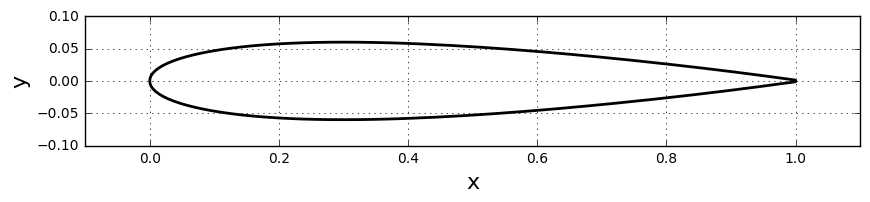

In [2]:
# read of the geometry from a data file
naca_filepath = os.path.join('resources', 'naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Discretization into panels

Like in [Lesson 9](09_Lesson09_flowOverCylinder.ipynb), we will create a discretization of the body geometry into panels (line segments in 2D). A panel's attributes are: its starting point, end point and mid-point, its length and its orientation. See the following figure for the nomenclature used in the code and equations below.

<img src="./resources/panelSketch.png" width="400">

We can modify the `Panel` class from our previous notebook slightly, to work better for our study of flow over an airfoil. The only difference is that we identify points on the top or bottom surfaces with the words `upper` and `lower`, which is only used later for plotting results with different colors for the top and bottom surfaces of the profile.

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

For the circular cylinder, the discretization into panels was really easy. This is the part that gets more complicated when you want to compute the flow around a general geometry, while the solution part is effectively the same as in [Lesson 9](09_Lesson09_flowOverCylinder.ipynb).

The function below will create the panels from the geometry data that was read from a file. It is better to have small panels near the leading-edge and the trailing edge, where the curvature is large. One method to get a non uniform distribution around the airfoil is to first discretize a circle with diameter equal to the airfoil's chord, with the leading edge and trailing edge touching the circle at a node, as shown in the following sketch.

<img src="./resources/naca0012_in_circle.png" width="300">

Then, we store the $x$-coordinates of the circle points, `x_circle`, which will also be the $x$-coordinates of the panel nodes, `x`, and project the $y$-coordinates of the circle points onto the airfoil by interpolation. We end up with a node distribution on the airfoil that is refined near the leading edge and the trailing edge. It will look like this:

<img src="./resources/naca0012_discretized_in_circle.png" width="300">

With the discretization method just described, the function `define_panels()` returns an array of objects, each an instance of the class `Panel` and containing all information about a panel, given the desired number of panels and the set of body coordinates.

A few remarks about the implementation of the function `define_panels()`:

* we just need to compute the $x$-coordinates of the circle (`x_circle`) since the $y$-coordinates of the panel nodes will be computed by interpolation;
* we create a circle with `N+1` points, but the first and last points coincide;
* we extend our NumPy arrays by adding an extra value that is equal to the first one; thus we don't have to do anything special with the value `x[i+1]` in the different loops;
* the *while*-loop is used to find two consecutive points, (`x[I]`,`y[I]`) and (`x[I+1]`,`y[I+1]`), on the foil such that the interval [`x[I]`,`x[I+1]`] contains the value `x_ends[i]`; we use the keyword `break` to get out of the loop;
* once the two points have been identified, the value `y_ends[i]` is computed by interpolation.

In [4]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max()-x.min())/2                                    # radius of the circle
    x_center = (x.max()+x.min())/2                             # x-coord of the center
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  # x-coord of the circle points
    
    x_ends = numpy.copy(x_circle)      # projection of the x-coord on the surface
    y_ends = numpy.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Now we can use this function, calling it with a desired number of panels whenever we execute the cell below. We also plot the resulting geometry.

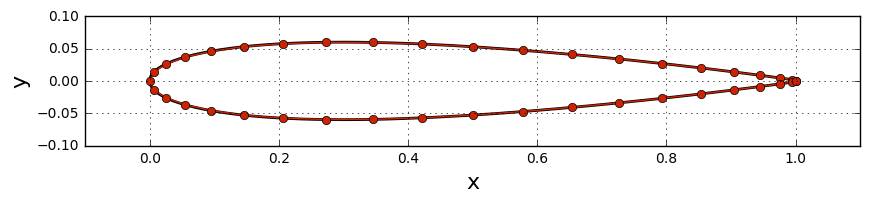

In [5]:
N = 40                            # number of panels
panels = define_panels(x, y, N)   # discretizes of the geometry into panels

# plot the geometry and the panels
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Freestream conditions

The NACA0012 airfoil will be immersed in a uniform flow with velocity $U_\infty$ and an angle of attack $\alpha=0$. Even though it may seem like overkill to create a class for the freestream, we'll do it anyway. When creating a class, one is expecting to also create several intances of its objects. Here, we just have one freestream, so why define a class? Well, it makes the code more readable and does not block the programer from using the variable names `u_inf` and `alpha` for something else outside of the class.
Also, every time we need the freestream condition as input to a function, we will just have to pass the object as an argument and not all the attributes of the freestream.

In [6]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [7]:
# define and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

## Flow tangency boundary condition

Enforcing the flow-tangency condition on each *control point* approximately makes the body geometry correspond to a dividing streamline (and the approximation improves if we represented the body with more and more panels). So, for each panel $i$, we make $u_n=0$ at $(x_{c_i},y_{c_i})$, which leads to the equation derived in the previous lesson:

\begin{equation}
u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0
\end{equation}

i.e.

\begin{equation}
0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{equation}

In the equation above, we calculate the derivative of the potential in the normal direction to enforce the flow tangency condition on each panel. But later, we will have to calculate the derivative in the tangential direction to compute the surface pressure coefficient. And, when we are interested in plotting the velocity field onto a mesh, we will have to calculate the derivative in the $x$- and $y$-direction.

Therefore the function below is similar to the one implemented in [Lesson 9](09_Lesson09_flowOverCylinder.ipynb) to obtain the integrals along each panel, but we've generalized it to adapt to the direction of derivation (by means of two new arguments, `dxdz` and `dydz`, which respectively represent the value of $\frac{\partial x_{c_i}}{\partial z_i}$ and $\frac{\partial y_{c_i}}{\partial z_i}$, $z_i$ being the desired direction).

Moreover, the function is also more general in the sense of allowing any evaluation point, not just a control point on a panel (the argument `p_i` has been replaced by the coordinates `x` and `y` of the control-point, and `p_j` has been replaced with `panel`).

In [8]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

## Building the linear system

Here, we build and solve the linear system of equations of the form

\begin{equation}[A][\sigma] = [b].\end{equation}

In building the matrix, below, we call the `integral()` function with the correct values for the last parameters: $\cos \beta_i$ and $\sin\beta_i$, corresponding to a derivative in the normal direction.

Finally, we use `linalg.solve()` from NumPy to solve the system and find the strength of each panel.

In [9]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [10]:
A = build_matrix(panels)                    # compute the singularity matrix
b = build_rhs(panels, freestream)           # compute the freestream RHS

In [11]:
# solve the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

## Surface pressure coefficient

From Bernoulli's equation, the pressure coefficient on the $i$-th panel is

\begin{equation}C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2
\end{equation}

where $u_{t_i}$ is the tangential component of the velocity at the center point of the $i$-th panel,

\begin{equation}
u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{equation}

with

\begin{equation}
\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i
\end{equation}

Notice that below we call the function `integral()` with different arguments: $-\sin\beta_i$ and $\cos\beta_i$ to get the derivation in the tangential direction.

In [12]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [13]:
# compute the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream)

In [14]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [15]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

### Theoretical solution

There is a classical method to obtain the theoretical characteristics of airfoils, known as *Theodorsen's method*. It uses the Joukowski transformation but is able to deal with any airfoil by an additional transformation between a "near circle" and a circle. The method is hairy indeed! But the resulting values of pressure coefficient are provided for some airfoils in table form in the 1945 [NACA Report No.824](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf), available from the NASA web server (see p. 71). 

The values of $(u/U_{\infty})^2$ are given for several stations along the chord length. We transcribed them here, saving them into an array:

In [16]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [17]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


### And plot the result!

We will use the values from the NACA report (also given in the book by Abbot and von Doenhoff, ["Theory of Wing Sections,"](http://books.google.com/books/about/Theory_of_Wing_Sections_Including_a_Summ.html?id=DPZYUGNyuboC) 1949) to visually compare the pressure distribution with the result of our source panel method. Let's see how it looks!

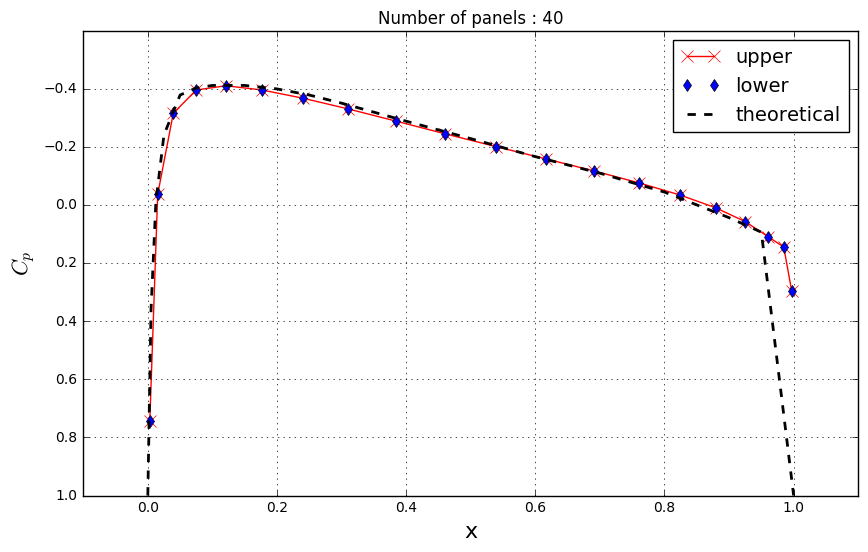

In [18]:
# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels : %d' % N);

That looks pretty good! The only place where the panel method doesn't quite match the tabulated data from Theordorsen's method is at the trailing edge. But note that the flow-tangency boundary condition in the panel method is applied at the control point of the panel (not at the endpoints), so this discrepancy is not surprising.

##### Accuracy check

For a closed body, the sum of all the source strengths must be zero. If not, it means the body would be adding or absorbing mass from the flow! Therfore, we should have

$$\sum_{j=1}^{N} \sigma_j l_j = 0$$

where $l_j$ is the length of the $j^{\text{th}}$ panel.

With this, we can get a get an idea of the accuracy of the source panel method.

In [19]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}'.format(accuracy))

--> sum of source/sink strengths: 0.004617031175283089


## Streamlines onto a mesh grid

To get a streamline plot, we have to create a mesh (like we've done in all *AeroPython* lessons!) and compute the velocity field onto it. Knowing the strength of every panel, we find the $x$-component of the velocity by taking derivative of the velocity potential in the $x$-direction, and the $y$-component by taking derivative in the $y$-direction:

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Notice that here we call the funcion `integral()` with $1,0$ as the final arguments when calculating the derivatives in the $x$-direction, and $0,1$ for the derivatives in th $y$-direction.

In addition, we use the function `numpy.vectorize()` (as we did in [Lesson 8](08_Lesson08_sourceSheet.ipynb)) to avoid the nested loops over the domain.

In [20]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0, 1)
    
    return u, v

In [21]:
# define a mesh grid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

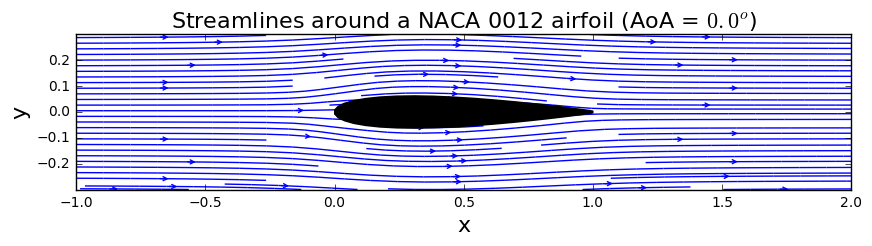

In [22]:
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha), fontsize=16);

We can now calculate the pressure coefficient. In Lesson 9, we computed the pressure coefficient on the surface of the circular cylinder. That was useful because we have an analytical solution for the surface pressure on a cylinder in potential flow. For an airfoil, we are interested to see how the pressure looks all around it, and we make a contour plot in the flow domain.

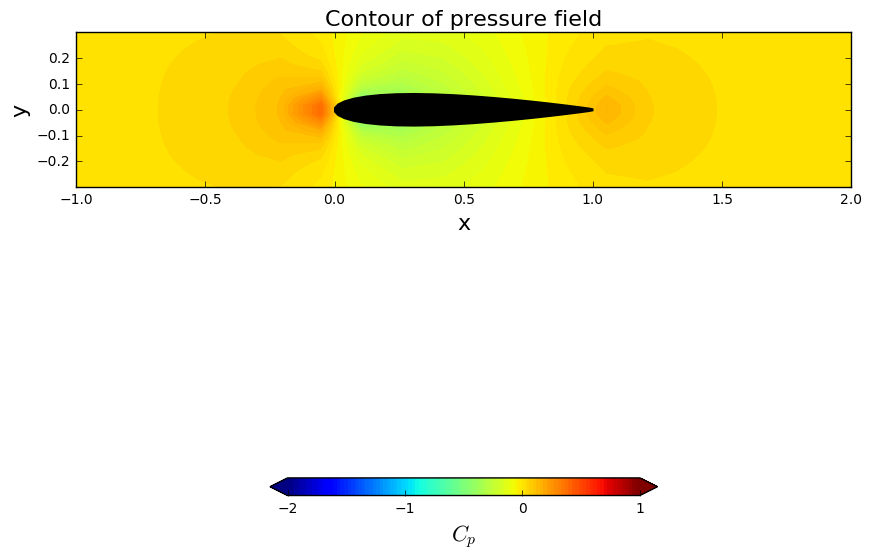

In [23]:
# compute the pressure field
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field', fontsize=16);

### Final words

We've learned to use a source-sheet to represent any solid body: first a [circular cylinder](09_Lesson09_flowOverCylinder.ipynb) (which we knew we could get by superposing a doublet and a freestream), and now an airfoil.

But what is the feature of airfoils that makes them interesting? Well, the fact that we can use them to generate lift and make things that fly, of course! But what do we need to generate lift? Think, think ... what is it?

## References

1. [Airfoil Tools](http://airfoiltools.com/index), website providing airfoil data.
1. Ira Herbert Abbott, Albert Edward Von Doenhoff and Louis S. Stivers, Jr. (1945), "Summary of Airfoil Data," NACA Report No.824, [PDF on the NASA web server](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf) (see p. 71)
1. Ira Herbert Abbott, Albert Edward Von Doenhoff, "Theory of Wing Sections, Including a Summary of Airfoil Data" (1949), Dover Press. 

A further reference on Theodorsen's method is:

* Roland Schinzinger, Patricio A. A. Laura (1991), "Conformal Mapping: Methods and Applications." Dover edition in 2003. [Read on Google Books](https://books.google.com/books?id=qe-7AQAAQBAJ&lpg=PA128&ots=wbg0jLlqq5&dq=method%20theodorsen&pg=PA128#v=onepage&q=%22method%20of%20theodorsen%20and%20garrick%22&f=false)


---

###### Please ignore the cell below. It just loads our style for the notebook.

In [24]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()